
# Training a TFNO on Darcy-Flow

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
import neuralop.training.callbacks as callbacks
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

Loading the Navier-Stokes dataset in 128x128 resolution



In [2]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        positional_encoding=True
)
data_processor = data_processor.to(device)

Loading test db at resolution 32 with 50 samples and batch-size=32


In [3]:
train_loader.dataset.x.shape

torch.Size([1000, 1, 16, 16])

We create a tensorized FNO model



In [4]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 523257 parameters.


Create the optimizer



In [5]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [6]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [7]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losse

Create the trainer



In [23]:
callback = callbacks.BasicLoggerCallback()
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  callbacks=[callback],
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [42]:
train_loader

In [16]:
for idx, sample in enumerate(train_loader):
        print(sample['x'].shape)
        print(sample['y'].shape)
        sample = data_processor.preprocess(sample)
        print(sample['x'].shape)
        print(sample['y'].shape)
        break

torch.Size([32, 1, 16, 16])
torch.Size([32, 1, 16, 16])
torch.Size([32, 3, 16, 16])
torch.Size([32, 1, 16, 16])


Actually train the model on our small Darcy-Flow dataset



In [26]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders, # Note: can be set to dict() if no test set is available
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [] samples         on resolutions [].
Raw outputs of size out.shape=torch.Size([32, 1, 16, 16])
[0] time=4.25, avg_loss=6.4790, train_err=4.0494


KeyboardInterrupt: 

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



/var/folders/35/rh4nk5bj77d599cgr_5j2hsm0000gn/T/ipykernel_7086/1474147971.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


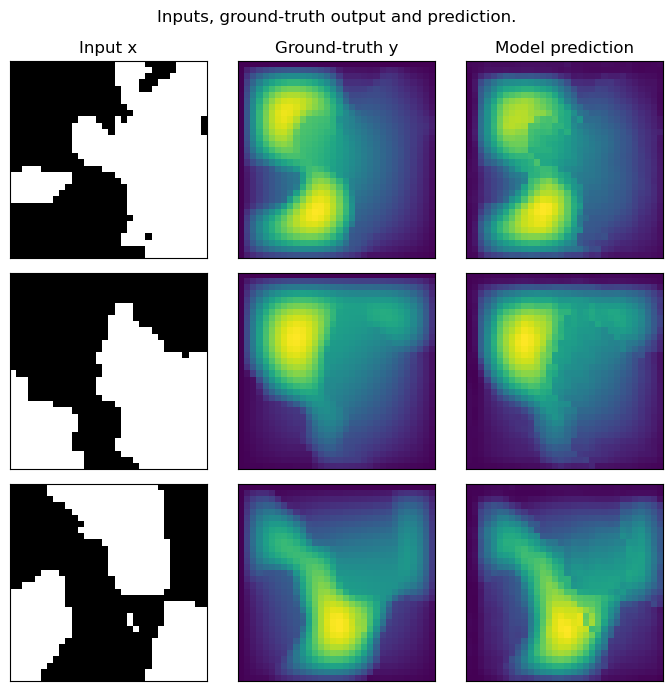

In [12]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()